# Annotation Code using SAM model

In [2]:
import os
import pickle
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

from utils import (
    show_mask, show_box, get_device
)

# Uncomment the following lines to download the model weights

# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/home/pradeep/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
device = get_device()

# Replace the path with the path to the working directory. 
im_dir = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project"

# Depending on the model you want to use, uncomment the appropriate line and set the path to the model weights
sam_checkpoint = f"{im_dir}/sam_vit_h_4b8939.pth"
# sam_checkpoint = f"{im_dir}/sam_vit_h_4b8939.pth"

model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

---

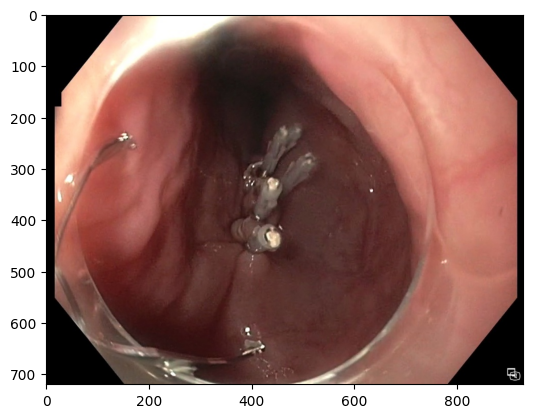

In [5]:
# Replace the path with the path to the annotations.pkl file. # We will store our masks in this file
pkl_path = f"{im_dir}/annotations.pkl"

# Replace the filename with the image you want to segment
filename = "Data/1.jpg"

image = cv2.imread(f"{im_dir}/{filename}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

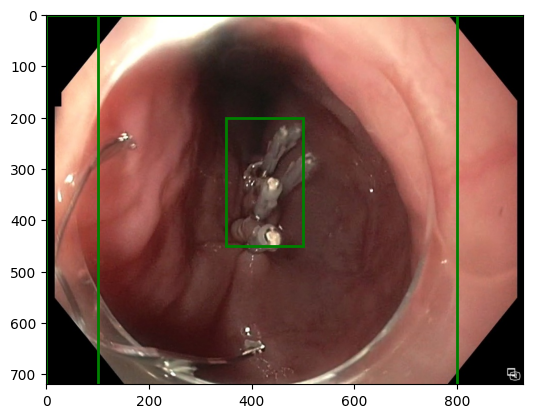

In [11]:
# Update the input_boxes tensor with the bounding boxes of the objects in the image
input_boxes = torch.tensor([

    # 0 - Background (Null class)
    [0, 0, *image.shape[1::-1]],

    # 1 - Muscle layer
    [100, 0, 800, 720],

    # 2 - Mucosal layer
    [0, 0, 0, 0],

    # 3 - Electrode
    [350, 200, 500, 450]

]).to(device)

plt.imshow(image)
for box in input_boxes:
    show_box(box.cpu(), plt.gca())
plt.show()

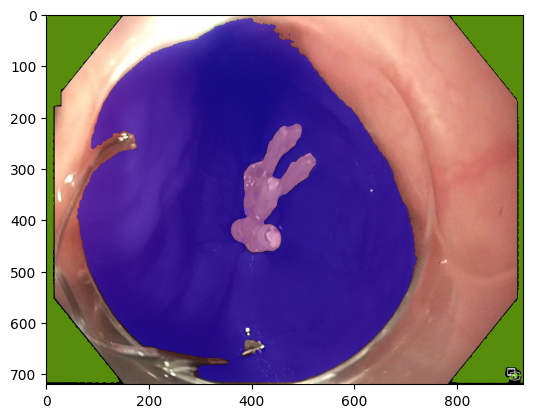

In [13]:
predictor.set_image(image)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.show()

In [32]:
# dictionary to store the masks. key = filename, value = list of masks
all_masks = {}

In [34]:
masks = masks.int()
all_masks[filename] = masks.squeeze().argmax(0).cpu()

len(all_masks)

1

---

In [35]:
masks.squeeze().argmax(0)[300, 400]

tensor(3)

In [36]:
with open(pkl_path, "wb") as file:
    pickle.dump(all_masks, file)

In [40]:
im_filenames = [
    im_file for im_file in os.listdir(f'{im_dir}/Data')
    if os.path.splitext(im_file)[1] == ".jpg"
]
filenames_iter = iter(im_filenames)

with open(pkl_path, "rb") as file:
    all_masks = pickle.load(file)

len(all_masks)

1

In [45]:
filename = next(filenames_iter)
while filename in all_masks.keys():
    filename = next(filenames_iter)

print(filename, filename in all_masks.keys(), sep="\n")

1.jpg
False


In [47]:
os.remove(f"{im_dir}/Data/{filename}")